In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from pathlib import Path
from analysis import emg, analysis, collection
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

### PCA dimenstionality for movement, calibration, trial chunks -- inspect relative, compare over subjects vs. reward

In [40]:
subject_idx = 0

movement_stack = np.load("subject_filtered_movement_stacks.npy")[subject_idx]
calibration_stack = np.load("subject_filtered_calibration_stacks.npy")[subject_idx]
trial_stack = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")

print(movement_stack.shape, calibration_stack.shape, trial_stack.shape)

(2, 14, 64, 2000) (2, 32, 64, 1000) (45, 12, 64, 2000)


In [41]:
movement_samples = analysis.remove_nan_rows(movement_stack.transpose(0,1,3,2).reshape(-1,64))
calibration_samples = analysis.remove_nan_rows(calibration_stack.transpose(0,1,3,2).reshape(-1,64))

In [42]:
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))
trial_chunks = []
for start, end in chunk_indices:
    s = trial_stack.transpose(0,1,3,2)[start:end].reshape(-1,64)
    ns = analysis.remove_nan_rows(s)
    trial_chunks.append(ns)

In [43]:
decoder = collection.get_decoder(subjects[subject_idx])

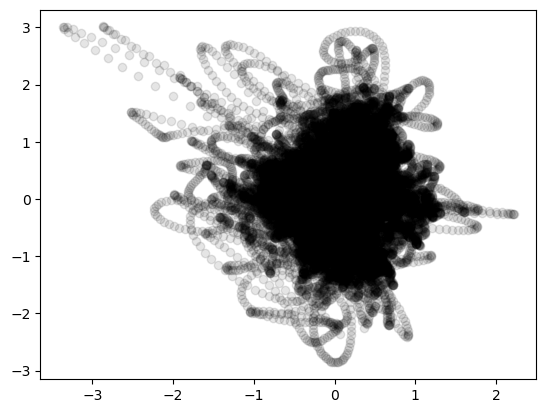

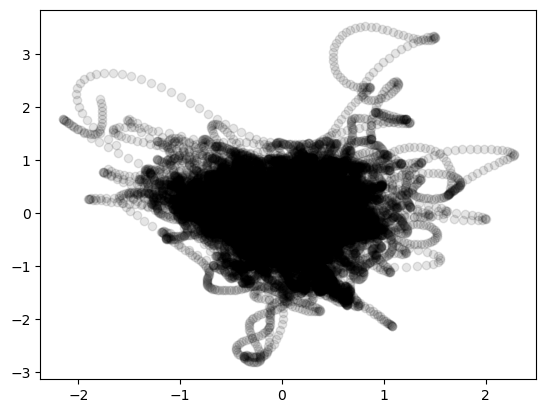

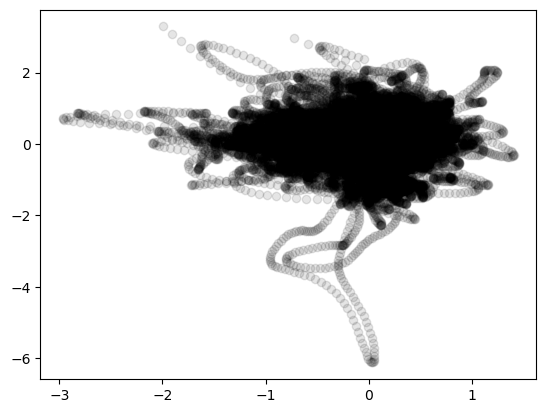

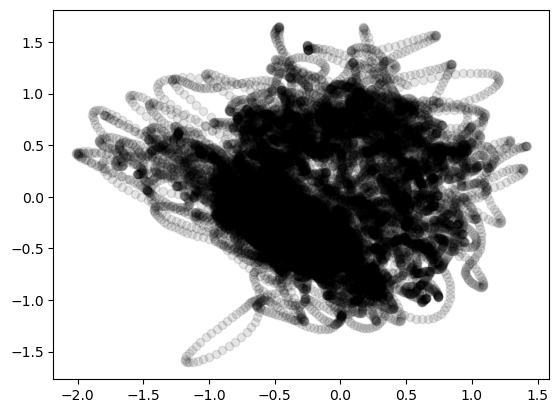

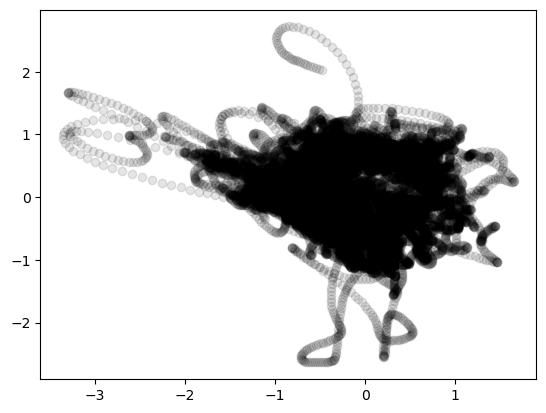

In [44]:
for chunk in trial_chunks:
    t = (chunk @ decoder.T).T
    plt.figure()
    plt.plot(t[0],t[1],"ko",alpha=0.1)

In [45]:
def nonzeros_over_rows(samples):
    return np.where(np.all(samples > 0,axis=1))[0]

samples = np.ones(shape=(25,1))

nonzeros_over_rows(samples).shape

(25,)

In [52]:
def log_emg_data(samples):
    assert len(samples.shape) == 2, samples.shape
    assert samples.shape[0] > samples.shape[1], samples.shape
    samples[:,56] = np.mean(samples[:,(56-8,56-16)],axis=1)
    greater_than_zero_idxs = nonzeros_over_rows(samples)
    sample_diff = samples.shape[0] - greater_than_zero_idxs.shape[0]
    if sample_diff > 0:        
        samples = samples[greater_than_zero_idxs,:]
        print(f"cut {sample_diff} samples")
    return np.log(samples)

In [47]:
def effective_rank(samples, n_svs=2):
    assert len(samples.shape) == 2, samples.shape
    assert samples.shape[0] > samples.shape[1], samples.shape
    U, S, V = np.linalg.svd(np.cov(samples.T))
    return S[:n_svs].sum()/S.sum()

In [48]:
movement_pca = PCA().fit(log_emg_data(movement_samples))
calibration_pca = PCA().fit(log_emg_data(calibration_samples))
chunk_pcas = []
for chunk in trial_chunks:
    chunk_pcas.append(PCA().fit(log_emg_data(chunk)))

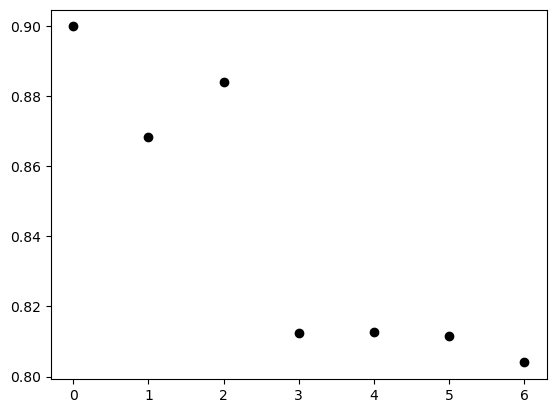

In [49]:
n_svs = 2
top_3_svs = [movement_pca.explained_variance_ratio_[:n_svs].sum(), calibration_pca.explained_variance_ratio_[:n_svs].sum()] + [c.explained_variance_ratio_[:n_svs].sum() for c in chunk_pcas]
plt.plot(top_3_svs,"ko")

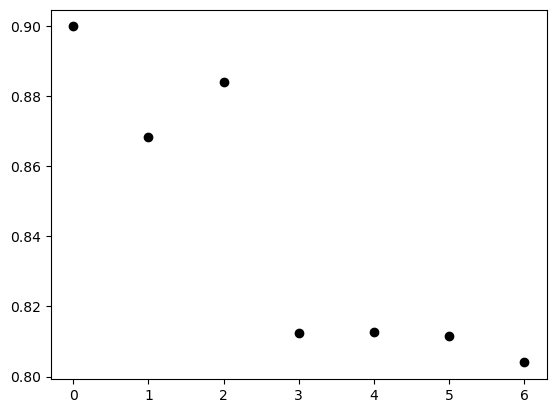

In [50]:
plt.plot([effective_rank(log_emg_data(movement_samples)), effective_rank(log_emg_data(calibration_samples))]+[effective_rank(log_emg_data(c)) for c in trial_chunks],"ko")

# over subjects

In [51]:
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))
n_svs = 2
top_svs = []
for subject_idx in range(46):
    movement_stack = np.load("subject_filtered_movement_stacks.npy")[subject_idx]
    calibration_stack = np.load("subject_filtered_calibration_stacks.npy")[subject_idx]
    trial_stack = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")

    movement_samples = analysis.remove_nan_rows(movement_stack.transpose(0,1,3,2).reshape(-1,64))
    calibration_samples = analysis.remove_nan_rows(calibration_stack.transpose(0,1,3,2).reshape(-1,64))

    trial_chunks = []
    for start, end in chunk_indices:
        s = trial_stack.transpose(0,1,3,2)[start:end].reshape(-1,64)
        ns = analysis.remove_nan_rows(s)
        trial_chunks.append(ns)

    movement_pca = PCA().fit(log_emg_data(movement_samples))
    # print(subject_idx, np.where(~np.isfinite(log_emg_data(calibration_samples))),np.where(calibration_samples<0))
    calibration_pca = PCA().fit(log_emg_data(calibration_samples))
    chunk_pcas = []
    for chunk in trial_chunks:
        chunk_pcas.append(PCA().fit(log_emg_data(chunk)))

    top_svs.append([movement_pca.explained_variance_ratio_[:n_svs].sum(), calibration_pca.explained_variance_ratio_[:n_svs].sum()] + [c.explained_variance_ratio_[:n_svs].sum() for c in chunk_pcas])
    

(38609,) (38615, 64)
(38609,) (38609, 64)
(35447,) (35452, 64)
(35447,) (35447, 64)
(36743,) (36750, 64)
(36743,) (36743, 64)
(23779,) (23780, 64)
(23779,) (23779, 64)
(37665,) (37668, 64)
(37665,) (37665, 64)
(33868,) (33875, 64)
(33868,) (33868, 64)
(34830,) (34833, 64)
(34830,) (34830, 64)
(31771,) (31777, 64)
(31771,) (31771, 64)
(21241,) (21311, 64)
(21241,) (21241, 64)
(35602,) (35675, 64)
(35602,) (35602, 64)
(36543,) (36549, 64)
(36543,) (36543, 64)
(40500,) (40505, 64)
(40500,) (40500, 64)
(32830,) (32831, 64)
(32830,) (32830, 64)
(40467,) (40475, 64)
(40467,) (40467, 64)
(27883,) (27886, 64)
(27883,) (27883, 64)
(34666,) (34684, 64)
(34666,) (34666, 64)
(44389,) (44414, 64)
(44389,) (44389, 64)
(39899,) (39953, 64)
(39899,) (39899, 64)
(42503,) (42555, 64)
(42503,) (42503, 64)


([<matplotlib.axis.XTick at 0x7f9651e84fe0>,
 [Text(0, 0, 'Movement'),
  Text(1, 0, 'Calibration'),
  Text(2, 0, 'Block 1'),
  Text(3, 0, 'Block 2'),
  Text(4, 0, 'Block 3'),
  Text(5, 0, 'Block 4'),
  Text(6, 0, 'Block 5')])

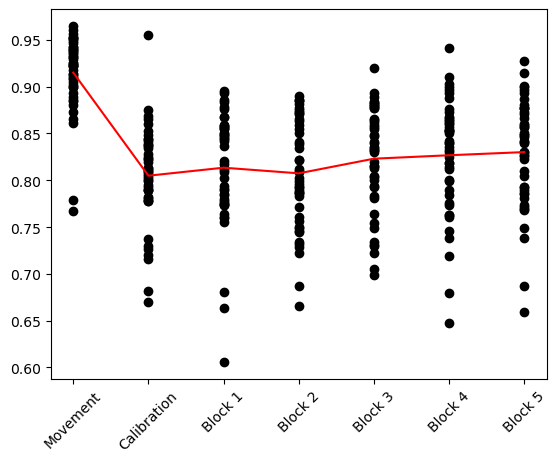

In [73]:
for s in top_svs:
    plt.plot(s,"ko")
plt.plot(np.mean(top_svs,axis=0),"r")
plt.xticks(range(7),labels=["Movement", "Calibration"] + [f"Block {i}" for i in range(1,6)],rotation=45)

In [54]:
mean_rewards = np.load("subject_rewards.npy")

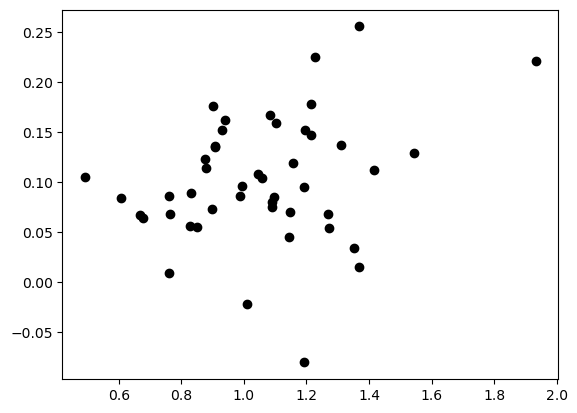

In [74]:
for r, s in zip(mean_rewards, top_svs):
    plt.plot(r,s[0]-s[2],"ko")